# Аналитика для Яндекс.Афиши

<hr style="border: 1px solid #000;"> 

## Описание проекта

Стажеру в отделе маркетинговой аналитики Яндекс.Афиши дано задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет. 
<br>
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов.

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта <br>
• Uid — уникальный идентификатор пользователя <br>
• Device — категория устройства пользователя <br>
• Start Ts — дата и время начала сессии <br>
• End Ts — дата и время окончания сессии <br>
• Source Id — идентификатор источника перехода на сайт <br>

<br>
orders_log.csv - инфо о заказах <br>
• Uid — уникальный идентификатор пользователя <br>
• Buy Ts — дата и время заказа <br>
• Revenue — сумма заказа <br>

<br>
costs.csv - о расходах на маркетинг <br>
• source_id — идентификатор рекламного источника <br>
• dt — дата проведения рекламной кампании <br>
• costs — расходы на эту кампанию <br><br>
Выручка измеряется в условных единицах — у.е.

Задачи: <br>
1. Посчитать метрики трёх видов: продуктовые, метрики электронной коммерции, маркетинговые. <br>
2. Отобразить на графиках изменения каждой метрики во времени.  <br>
3. Сформулировать выводы. <br>


<hr style="border: 1px solid #000;"> 

## Обзор и подготовка данных

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs.csv')

### visits

In [3]:
visits.info() 
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Нужно отредактировать названия столбцов, а также поменять тип object на datetime у End Ts и Start Ts.

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ','_')
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [5]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [6]:
visits.duplicated().sum()

0

In [7]:
visits.isna().mean()

device       0.0
end_ts       0.0
source_id    0.0
start_ts     0.0
uid          0.0
dtype: float64

Пропусков и дубликатов нет.

### orders

In [8]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Внесем аналогичные предыдущему пункту изменения.

In [9]:
orders.columns = orders.columns.str.lower().str.replace(' ','_')
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [10]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [11]:
orders.duplicated().sum()

0

In [12]:
visits.isna().mean()

device       0.0
end_ts       0.0
source_id    0.0
start_ts     0.0
uid          0.0
dtype: float64

Пропусков и дубликатов нет.

### costs

In [13]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Столбец dt имеет тип object, меняем его.

In [14]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs = costs.rename(columns={'dt':'date'})

In [15]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [16]:
costs.duplicated().sum()

0

In [17]:
costs.isna().mean()

source_id    0.0
date         0.0
costs        0.0
dtype: float64

Пропусков и дубликатов нет.

Мы ознакомились с тремя таблицами, изменили в нужных местах тип данных на datetime, привели названия столбцов к нижнему регистру. Узнали, что дубликаты и пропуски отсутствуют.

## Продуктовые метрики

### DAU, WAU и MAU

Работаем с таблицей visits. Чтобы посчитать dau, wau, mau выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [18]:
visits['session_day'] = visits['start_ts'].astype('datetime64[D]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

visits['session_year']  = visits['start_ts'].dt.year
visits['session_date'] = visits['start_ts'].dt.date
visits['n_week'] = visits['start_ts'].dt.week


И добавим столбец с длительностью сессии в секундах

In [19]:
#visits['duration'] = ((visits['end_ts'] - visits['start_ts'])/ np.timedelta64(1,'s')).astype(int)
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [20]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid,session_day,session_week,session_month,session_year,session_date,n_week,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017,2017-12-20,51,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018,2018-02-19,8,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017,2017-07-01,26,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018,2018-05-20,20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017,2017-12-27,52,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-31,2017-09-01,2017,2017-09-03,35,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,2018-01-25,2018-01-01,2018,2018-01-30,5,3360
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,2017-11-02,2017-11-01,2017,2017-11-05,44,60
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,2017-07-13,2017-07-01,2017,2017-07-19,29,180
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,2017-11-02,2017-11-01,2017,2017-11-08,45,60


Сгруппируем данные по уникальным пользователям и вычислим средние значения этих метрик за весь период, затем отобразим изменения метрик во времени на графиках.

In [21]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean() 
wau_total = visits.groupby(['session_year', 'session_week']).agg(
    {'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg(
    {'uid': 'nunique'}).mean()


In [22]:
int(dau_total)

907

количество уникальных пользователей в день

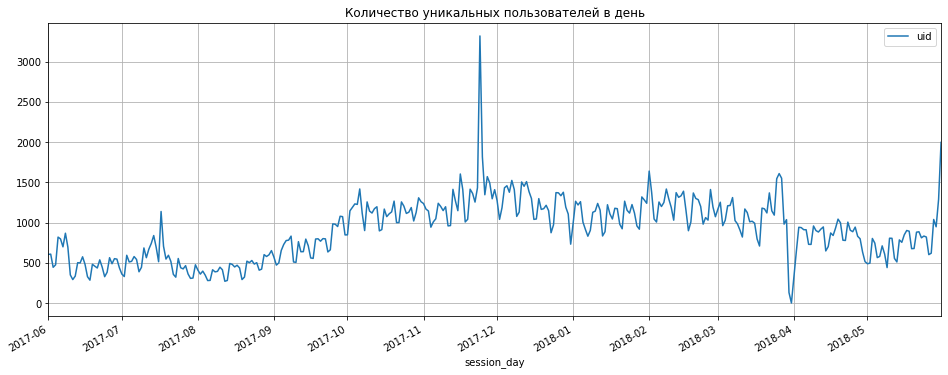

In [23]:
day = visits.groupby('session_day').agg({'uid': 'nunique'}).reset_index()
day.plot.line(x = 'session_day', y ='uid', figsize = (16,6), grid = True)

plt.title('Количество уникальных пользователей в день')     
plt.show()

Видим кардиограмму: каждую неделю происходит взлет посещений и падение. Очевиден также пик перед Новым годом и минимум 0 на стыке марта-апреля 18 г (может, сайт упал на какое-то время).

In [24]:
int(wau_total)

5621

количество уникальных пользователей в неделю

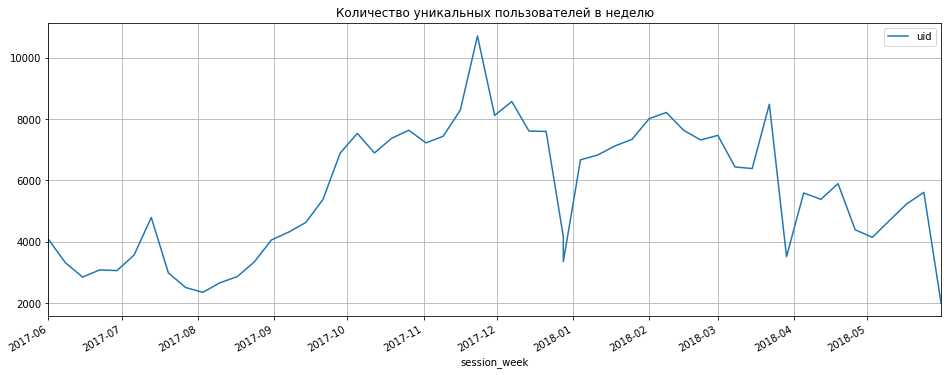

In [25]:
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
week = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).reset_index()
week.plot.line(x = 'session_week', y ='uid', figsize = (16,6), grid = True)

plt.title('Количество уникальных пользователей в неделю')     
plt.show()

Здесь уже видно, что в летнее время количество посещений низкое. Пик на Новый год, затем январское падение.

In [26]:
int(mau_total)

23228

количество уникальных пользователей в месяц

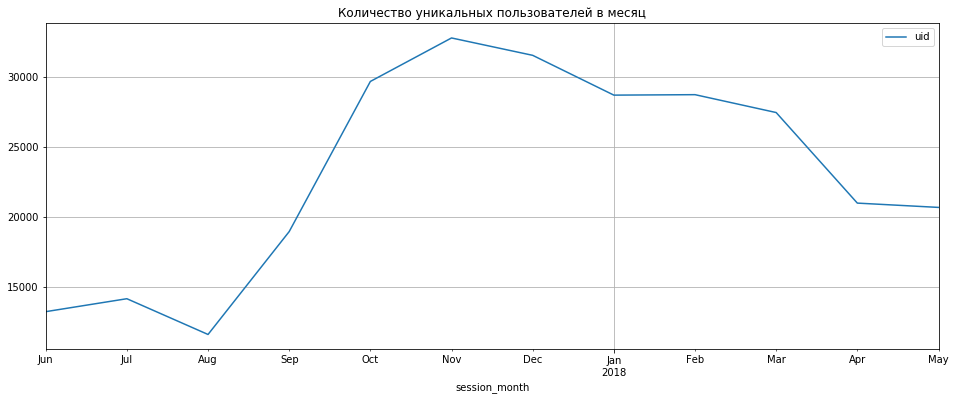

In [27]:
month = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).reset_index()
month.plot.line(x = 'session_month', y ='uid', figsize = (16,6), grid = True)

plt.title('Количество уникальных пользователей в месяц')     
plt.show()

На этом графике виден непрерывный рост с августа  по ноябрь, затем плавное падение.

In [28]:
sticky_wau = dau_total/wau_total*100
sticky_wau

uid    16.151541
dtype: float64

In [29]:
sticky_mau = dau_total/mau_total*100
sticky_mau

uid    3.90897
dtype: float64

Посчитали метрику sticky factor по отношению к месячной и недельной аудитории - почти 4% и 16% соответственно. Она показывает вовлеченность и регулярность использования.

### Количество сессий в день

Cколько сессий приходится на одного пользователя за день (показатель регулярности использования).
Разделим число сессий на количество пользователей за период

In [30]:
sessions_per_user = visits.groupby(['session_year', 'session_month', 'session_date']).agg(
    {'uid': ['count', 'nunique']}) 
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users'])

sessions_per_user = sessions_per_user.reset_index()
sessions_per_user

,session_year,session_month,session_date,n_sessions,n_users,sessions_per_user
0,2017,2017-06-01,2017-06-01,664,605,1.097521
1,2017,2017-06-01,2017-06-02,658,608,1.082237
2,2017,2017-06-01,2017-06-03,477,445,1.071910
3,2017,2017-06-01,2017-06-04,510,476,1.071429
4,2017,2017-06-01,2017-06-05,893,820,1.089024
...,...,...,...,...,...,...
359,2018,2018-05-01,2018-05-27,672,620,1.083871
360,2018,2018-05-01,2018-05-28,1156,1039,1.112608
361,2018,2018-05-01,2018-05-29,1035,948,1.091772
362,2018,2018-05-01,2018-05-30,1410,1289,1.093871


В день один пользователь в среднем проводит 1 сессию. Регулярность высокая.

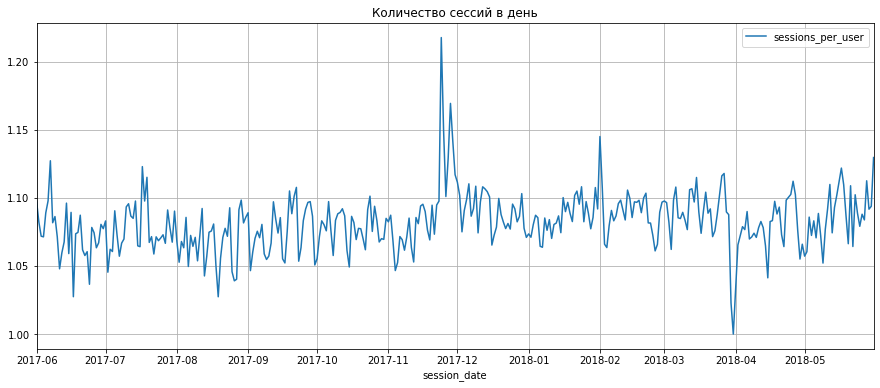

In [31]:
sessions_per_user.plot(x = 'session_date', y = 'sessions_per_user', figsize = (15,6), grid = True)

plt.title('Количество сессий в день')    
plt.show()

Результат reset_index сохранила обратно в фрейм. График получился снова похожим на кардиограмму: каждую неделю происходит взлет посещений и падение.

In [32]:
sessions_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 6 columns):
session_year         364 non-null int64
session_month        364 non-null datetime64[ns]
session_date         364 non-null object
n_sessions           364 non-null int64
n_users              364 non-null int64
sessions_per_user    364 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 17.2+ KB


### ASL длительность сессии

In [33]:
visits['duration'].mean().round()

644.0

Посчитали ранее длину всех сессий, вычисляем среднее. Около 10,5 минут в среднем длится сессия. Посмотрим на распределение.

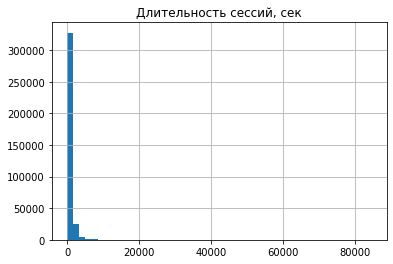

In [34]:
visits['duration'].hist(bins=50) 
plt.title('Длительность сессий, сек')
plt.show()

In [35]:
visits['duration'].median()

300.0

5 минут - медианная длительность сессии. Достаточное количество времени, чтобы сделать заказ.

In [36]:
visits['duration'].mode()

0    60
dtype: int64

In [37]:
visits['duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: duration, dtype: float64

Мне кажется медиана подходит лучше в этом случае. <br> Рассчитали моду - 60 сек. 60 секунд - это 10-11 перцентиль, тогда большинство сессий имеют бОльшую длительность? Но ведь мода показывает значения с наибольшей частотой. Непонятно. <br> За минуту можно найти нужное событие или положить в корзину или закончить оформление заказа. Не исключается, что можно сделать все шаги за 1 минуту..  <br>
    

### Retention Rate 

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.
Чем дольше привлечённый пользователь пользуется продуктом, тем выше потенциальная выручка. Это касается продуктов, зарабатывающих с пользователей напрямую, например, сервисов с подпиской.

Возьмём дату, когда пользователь впервые проявил активность.
Эти данные запишем в объект Series first_session_month. Объединим его с исходным датафреймом visits.

In [38]:
first_session_month = visits.groupby('uid')['session_month'].min()
first_session_month.name = 'first_session_month'
visits = visits.join(first_session_month, on='uid')
visits

,device,end_ts,source_id,start_ts,uid,session_day,session_week,session_month,session_year,session_date,n_week,duration,first_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017,2017-12-20,51,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018,2018-02-19,8,1680,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017,2017-07-01,26,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018,2018-05-20,20,1440,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017,2017-12-27,52,0,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-27,2017-07-01,2017,2017-07-29,30,19,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-25,2018-01-01,2018,2018-01-25,4,19,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018-03-01,2018,2018-03-03,9,19,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-02,2017-11-01,2017,2017-11-02,44,19,2017-11-01


Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты. 
Эта метрика для каждого события отображает, в каком по счёту месяце от месяца когорты оно произошло. 


In [39]:
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits['cohort_lifetime'].head(10) 

0    0
1    0
2    0
3    2
4    0
5    0
6    7
7    0
8    0
9    0
Name: cohort_lifetime, dtype: int64

Получили целое число месяцев, обозначающее порядковый месяц совершения покупки относительно месяца первой покупки. <br>
Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни»

In [40]:
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [41]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']] 
initial_users_count

,first_session_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Переименуем столбец user_id в cohort_users методом rename(). Объединим данные по когортам с исходным количеством пользователей в когорте


In [42]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_session_month') 
cohorts.head()

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [43]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
cohorts['first_session_month'] = cohorts['first_session_month'].dt.strftime('%Y-%m')

In [44]:
cohorts

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06,0,13259,13259,1.000000
1,2017-06,1,1043,13259,0.078664
2,2017-06,2,713,13259,0.053775
3,2017-06,3,814,13259,0.061392
4,2017-06,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03,1,861,20589,0.041818
74,2018-03,2,557,20589,0.027053
75,2018-04,0,15709,15709,1.000000
76,2018-04,1,760,15709,0.048380


Построим сводную таблицу и создадим тепловую карту

In [45]:
retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

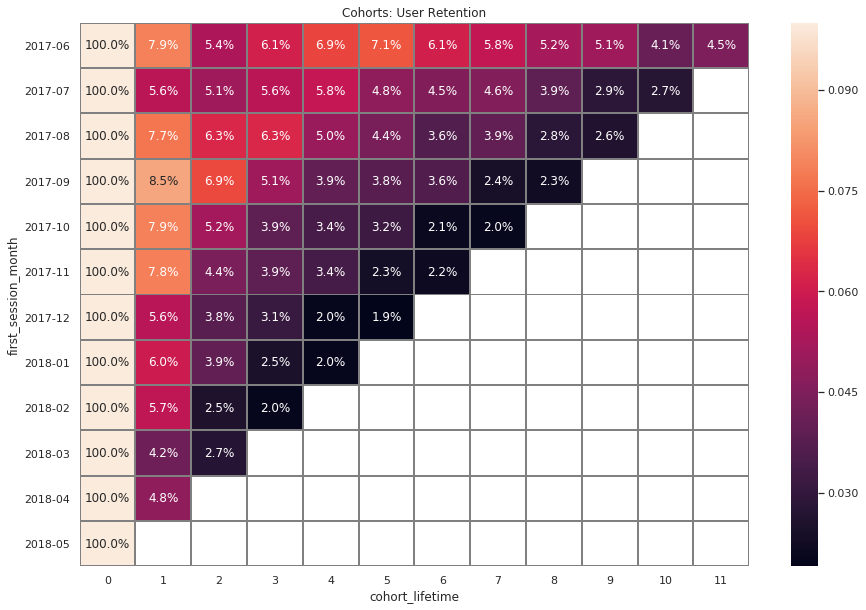

In [46]:
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1) 
plt.show()

Retention Rate в целом низкий и убывает по когортам с течением времени. Если для когорты пользователей, пришедших в июне 2017 Retention Rate в первую неделю составляет 7,9%, то для пользователей, пришедших в апреле 2018 — уже 4,8%. За 10 мес коэффициент удержания упал на 3,1%. Это говорит, что с каждой новой когортой поведение покупателей меняется.  <br>

Коэффициент удержания у первой когорты заметно выше, чем у других; маркетологам нужно внимательно изучить эту когорту и выяснить  причины лояльности. Выделяется июльская когорта - в середине лета пользователей меньше.

## Метрики электронной коммерции

Работаем с дф orders и visits.

### Когда люди начинают покупать

In [47]:
# сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

Найдем дату первого заказа в orders и дату первой сессии в visits

In [48]:
first_order_date = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order_date.columns = ['uid', 'first_order_date']
first_session_date = visits.groupby('uid')['start_ts'].min().reset_index()
first_session_date.columns = ['uid', 'first_session_date']


Объединим в один дф

In [49]:
first_buy = first_order_date.merge(first_session_date, on='uid')
first_buy.head()

,uid,first_order_date,first_session_date
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Вычислим разницу между первым заказом и первой сессией в днях, далее переведем в минуты.

In [50]:
first_buy['interval_days'] = first_buy['first_order_date'] - first_buy['first_session_date']
first_buy['interval_m'] = first_buy['interval_days']/np.timedelta64(1, 'm')

In [51]:
first_buy

,uid,first_order_date,first_session_date,interval_days,interval_m
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00,0.0
...,...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,95 days 19:33:00,137973.0
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,0 days 00:07:00,7.0
36520,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,231 days 11:03:00,333303.0
36521,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,103 days 09:33:00,148893.0


Построим распределение разницы, найдем среднюю и медианную разницу.

In [52]:
first_buy['interval_m'].median()

16.0

In [53]:
first_buy['interval_m'].mean().astype(int)

24340

Медиана разницы во времени с момента первого посещения сайта до совершения покупки - 16 минут. 

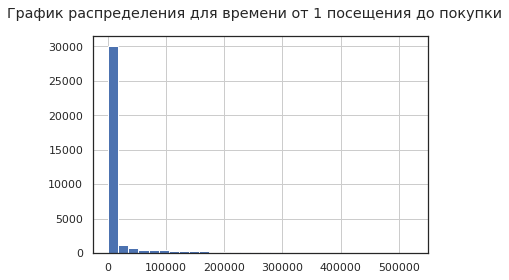

In [54]:
first_buy['interval_m'].hist(bins=30)
plt.suptitle('График распределения для времени от 1 посещения до покупки');
plt.show()

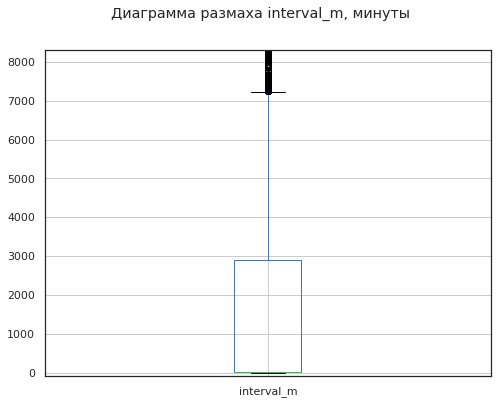

In [55]:
plt.figure(figsize=(8,6))
first_buy.boxplot(column='interval_m',  grid = True)
plt.suptitle('Диаграмма размаха interval_m, минуты')
plt.ylim(-100, 8300)
plt.show()

Среднее 24340. Медиана 16. В среднем количество от 0 до 2800 (межквартильный интервал). Размах от 0 до 7200, свыше идут выбросы.

In [56]:
#first_buy['interval_days'].describe()
first_buy['interval_m'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: interval_m, dtype: float64

вывод после боксплота - большинство пользователей совершает покупку во время своей первой сессии.

In [57]:
first_buy['interval_m'].mode()

0    1.0
dtype: float64

Посчитали моду - 1 минута. То есть 1 минута в среднем проходит с момента первого посещения сайта до совершения покупки<br> Если мы видим что покупают большинство товаров за одну минуту - этом может быть и баг и ошибки в данных, а может наоборот, наша новая опция купить в один клик показывает отличные результаты. 

### Сколько раз покупают за период?

In [59]:
orders['buy_ts'].describe() 

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Первая покупка состоялась 1 июня 2017 года. Последняя — 1 июня 2018 года. Изучим файл с расходами

In [69]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['week'] = orders['buy_ts'].dt.week

In [71]:
orders

,buy_ts,revenue,uid,order_month,week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,22
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,22
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,22
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,22
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,22
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,22
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,22
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,22
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,22


In [72]:
# соединяем заказы с первыми заказами
orders = orders.merge(orders.groupby('uid').agg({'order_month': 'min'})
                            .rename(columns = {'order_month': 'first_order_month'}).reset_index(),
                      on = 'uid', how = 'left')
 

In [73]:
# получаем размеры когорт покупателей 
cohort_sizes = (orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers'] 
 

In [74]:
# группируем покупки по дате когорты и дате покупки, считаем число покупок
cohorts = (orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'count'}).reset_index())
report = pd.merge(cohort_sizes, cohorts, on='first_order_month') 

In [75]:
# рассчитываем лайфтайм
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int') 

In [76]:
# считаем среднее число покупок
report['mean_orders'] = report['revenue'] / report['n_buyers']
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')
report.head()

,first_order_month,n_buyers,order_month,revenue,age,mean_orders
0,2017-06,2023,2017-06-01,2354,0,1.163618
1,2017-06,2023,2017-07-01,177,1,0.087494
2,2017-06,2023,2017-08-01,174,2,0.086011
3,2017-06,2023,2017-09-01,226,3,0.111715
4,2017-06,2023,2017-10-01,292,4,0.144340


In [77]:
# считаем накопительное число покупок
revenue_cum = report.pivot_table(index='first_order_month', 
                   columns='age', 
                   values='mean_orders', 
                   aggfunc='sum').cumsum(axis = 1)
#revenue_cum = revenue_cum.cumsum(axis = 1).round(2).fillna(0)
revenue_cum

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.837370,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,NaN
2017-08,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.597080,NaN,NaN
2017-09,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,NaN,NaN,NaN
2017-10,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023,1.354839,1.383641,NaN,NaN,NaN,NaN
2017-11,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730,1.445724,NaN,NaN,NaN,NaN,NaN
2017-12,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.121554,1.187963,1.235102,1.254076,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.121611,1.182416,1.205149,1.224322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


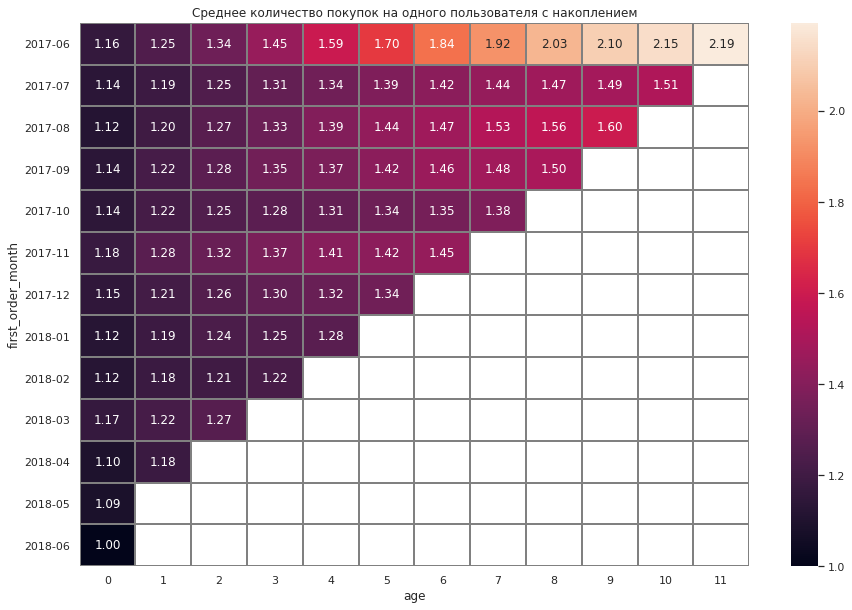

In [78]:
# строим тепловую карту
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('Среднее количество покупок на одного пользователя с накоплением')
sns.heatmap(revenue_cum, annot=True, fmt='.2f', linewidths=1, linecolor='gray') 
plt.show()

In [81]:
m6_cum = revenue_cum.cumsum(axis=1) 
m6_cum[5].mean()

7.820097325169913

Построили когорты и посчитали среднее число покупок для каждой когорты с накоплением. <br> На графике видно, что показатель у всех когорт с каждым месяцем увеличивается.
Первая когорта с высоким Retention снова в лидерах.  Она совершают больше покупок в месяц.
Среднее количество покупок на одного покупателя за 6 месяцев = 7,8 у.е.
     

### Средний чек

In [92]:
orders['revenue'].median()

2.5

In [93]:
orders['revenue'].mode()

0    1.83
dtype: float64

In [94]:
orders_chek = orders.groupby(['order_month']).agg({'revenue': 'median'})
#orders_chek

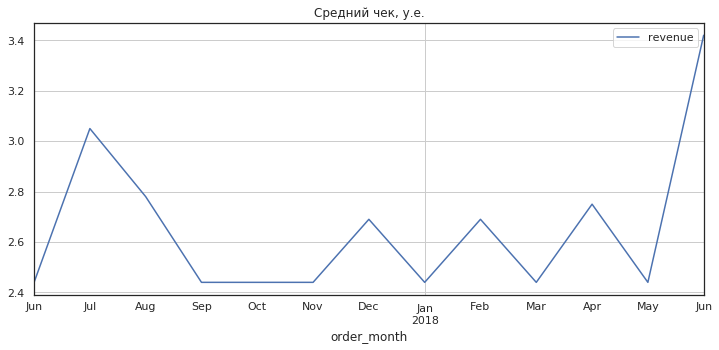

In [95]:
orders_chek.plot.line(figsize = (12,5), grid = True) 

plt.title('Средний чек, у.е.')     
plt.show()

В задании написано, что когортный анализ не подходит. <br>  Посчитали средний чек по медиане просто по всем данным по месяцам, построили график. Максимальный чек в июле 2017 и июне 2018. <br> минимальный в июне 2017, январе и июне 2018. <br> </div>

>>**<span style="color:green">Update: Здесь все правильно, молодец!</span>**


### Сколько денег приносят? (LTV)

In [100]:
cohort_sizes_ltv = (orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes_ltv.columns = ['first_order_month', 'n_buyers'] 

cohorts_ltv = (orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'count', 'revenue': 'sum'}).reset_index())
report_ltv = pd.merge(cohort_sizes_ltv, cohorts_ltv, on='first_order_month')
report_ltv.head(10)

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
5,2017-06-01,2023,2017-11-01,1487.92
6,2017-06-01,2023,2017-12-01,1922.74
7,2017-06-01,2023,2018-01-01,1176.56
8,2017-06-01,2023,2018-02-01,1119.15
9,2017-06-01,2023,2018-03-01,1225.51


In [101]:
margin_rate = 1

report_ltv['gp'] = report_ltv['revenue'] * margin_rate
report_ltv['age'] = (report_ltv['order_month'] - report_ltv['first_order_month']) / np.timedelta64(1, 'M')
report_ltv['age'] = report_ltv['age'].round().astype('int')
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers']

report_ltv['first_order_month'] = report_ltv['first_order_month'].dt.strftime('%Y-%m')
report_ltv.head(10) 

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06,2023,2017-10-01,2068.58,2068.58,4,1.022531
5,2017-06,2023,2017-11-01,1487.92,1487.92,5,0.735502
6,2017-06,2023,2017-12-01,1922.74,1922.74,6,0.950440
7,2017-06,2023,2018-01-01,1176.56,1176.56,7,0.581592
8,2017-06,2023,2018-02-01,1119.15,1119.15,8,0.553213
9,2017-06,2023,2018-03-01,1225.51,1225.51,9,0.605788


In [102]:
output_ltv = report_ltv.pivot_table(index='first_order_month', 
                                    columns='age', values='ltv', 
                                    aggfunc='mean').cumsum(axis=1)

#output_ltv = output_ltv.cumsum(axis=1).fillna(0)
output_ltv

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


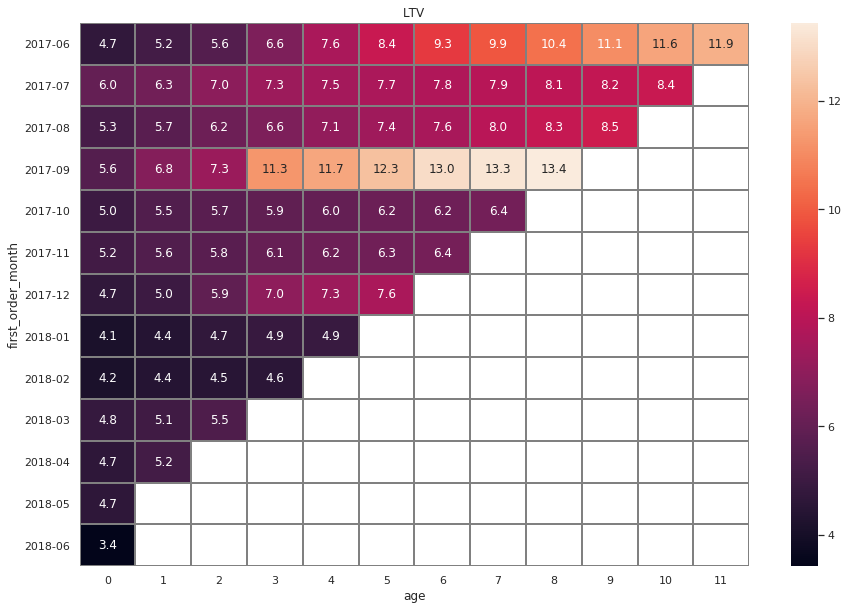

In [103]:
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('LTV')
sns.heatmap(output_ltv, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

In [104]:
# средний LTV по когортам за 6 месяцев 
m6_ltv = output_ltv.cumsum(axis=1) 
m6_ltv[5].mean()

40.02846357900007

LTV всех когорт увеличивается со временем. Накопительный LTV намного выше у первых когорт 2017г.
Первая когорта почти в каждом месяце она имеет высший LTV среди всех когорт. Ведь именно эта когорта показала лучший показатель Retention.
В когорте сентября на третий месяц жизни наблюдаем резкий скачок LTV - необходимо исследовать это подробнее.<br>
Средний LTV за полгода = 40 у.е.

## Маркетинговые метрики

### Сумма расходов на маркетинг

In [105]:
costs['costs_date_month'] = costs['date'].dt.month

Потратили всего денег:

In [106]:
costs['costs'].sum()

329131.62

Потратили денег на каждый источник:

In [107]:
costs.groupby('source_id').agg({'costs': 'sum'})

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


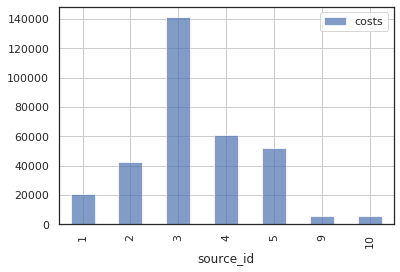

In [108]:
costs.groupby('source_id').agg({'costs': 'sum'}).plot(kind = 'bar', grid= True, alpha=0.7)
plt.show()

Третий источник - безоговорочный лидер по суммарным тратам, более 50% от суммы всех вложений. На 2м месте четвертый источник - но на него потрачено в 2,3 раза  меньше. Далее 4, 5, 1. Самый низкий бюджет у 9 и 10.

Потратили денег по дням:

In [109]:
costs_month = costs.groupby(['date']).agg({'costs': 'sum'}).reset_index()
costs_month.head()

,date,costs
0,2017-06-01,735.26
1,2017-06-02,721.19
2,2017-06-03,450.85
3,2017-06-04,761.16
4,2017-06-05,821.44


In [113]:
costs_month = costs.groupby(['source_id', 'costs_date_month']).agg({'costs': 'sum'}).reset_index() 

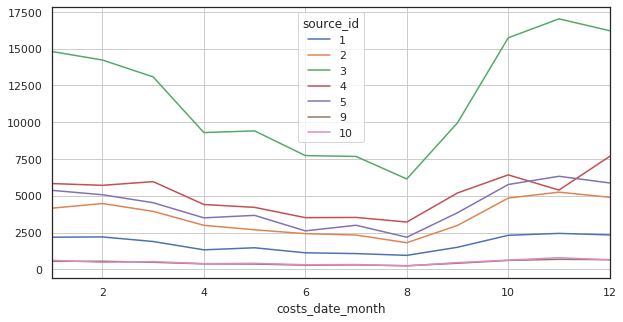

In [114]:
costs_month.pivot_table(index = 'costs_date_month', 
                        columns = 'source_id', values = 'costs', 
                        aggfunc = 'mean').plot(figsize = (10, 5), grid = True)
plt.show()

Здесь видно, что по месяцам на третий источник тоже тратят самый большой бюджет, затем идут 4 и 5й. Во все источники вкладывают максимум в зимний период с октября по январь, минимум - в августе.

### CAC

Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразите изменения метрик на графиках

In [115]:
# задаем по чему будем группировать 
group_dimensions = ['source_id']

# считаем расходы
monthly_costs_cource = costs.groupby(group_dimensions)['costs'].sum() 
costs['month'] = costs['date'].astype('datetime64[M]') 

In [116]:
source_users = visits[['source_id', 'uid', 'start_ts']].copy()
 
first_order = orders.groupby(['uid']).agg({'order_month': ['min']}).reset_index()
first_order.columns = ['uid', 'first_order_month']
first_order_month = pd.merge(orders, first_order, on='uid')

In [117]:
# группируем по пользователю и для каждого находим первый месяц и источник
users = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first', 'session_month':'first'})
users = users.reset_index().rename(columns = {'session_month': 'month'}) 

# выбираем иточник
source = 1

# отбираем только платящих из нужного источника
source_users = users.query('source_id == @source').index.values
source_orders = users.query('uid in @source_users') 

In [118]:
# соединяем заказы с первыми заказами
orders = orders.merge(orders.groupby('uid').agg({'order_month': 'min'})
                            .rename(columns = {'order_month': 'first_order_month'}).reset_index(),
                      on = 'uid', how = 'left')
 

In [123]:

# средний СAC по всем группам
round(costs['costs'].sum() / orders['uid'].nunique(), 2)

9.01

In [125]:
# затраты по месяцам
monthly_costs = costs.groupby('month').sum()


In [133]:
monthly_costs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2017-06-01 to 2018-05-01
Data columns (total 3 columns):
source_id           12 non-null int64
costs               12 non-null float64
costs_date_month    12 non-null int64
dtypes: float64(1), int64(2)
memory usage: 384.0 bytes


In [134]:
report.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 6 columns):
first_order_month    79 non-null datetime64[ns]
n_buyers             79 non-null int64
order_month          79 non-null datetime64[ns]
revenue              79 non-null int64
age                  79 non-null int64
mean_orders          79 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 4.3 KB


In [128]:
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report['order_month'] = report['order_month'].astype('datetime64[M]')

In [129]:
#report['first_order_month'] = report['first_order_month'].dt.month
#report['order_month'] = report['order_month'].dt.month

In [130]:
report 

,first_order_month,n_buyers,order_month,revenue,age,mean_orders
0,2017-06-01,2023,2017-06-01,2354,0,1.163618
1,2017-06-01,2023,2017-07-01,177,1,0.087494
2,2017-06-01,2023,2017-08-01,174,2,0.086011
3,2017-06-01,2023,2017-09-01,226,3,0.111715
4,2017-06-01,2023,2017-10-01,292,4,0.144340
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2,0.049816
75,2018-04-01,2276,2018-04-01,2495,0,1.096221
76,2018-04-01,2276,2018-05-01,195,1,0.085677
77,2018-05-01,2988,2018-05-01,3249,0,1.087349


In [131]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

report_new['first_order_month'] = report_new['first_order_month'].dt.strftime('%Y-%m')
report_new.head() 

,first_order_month,n_buyers,order_month,revenue,age,mean_orders,source_id,costs,costs_date_month,cac
0,2017-06,2023,2017-06-01,2354,0,1.163618,1020,18015.0,1260,8.905091
1,2017-06,2023,2017-07-01,177,1,0.087494,1020,18015.0,1260,8.905091
2,2017-06,2023,2017-08-01,174,2,0.086011,1020,18015.0,1260,8.905091
3,2017-06,2023,2017-09-01,226,3,0.111715,1020,18015.0,1260,8.905091
4,2017-06,2023,2017-10-01,292,4,0.144340,1020,18015.0,1260,8.905091


In [135]:
# средний CAC на одного покупателя для всего проекта 
report_new['cac'].median()

9.288870374908106

### ROMI

In [139]:
# определяем источник прихода пользователей
users = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first', 'session_month':'first'})

# объединяем пользователей с данными о источнике 1 визита с заказами
df1 = pd.merge(users, orders, on = 'uid')
orders_newest = df1.merge(orders.groupby('uid').agg({'order_month': 'min'}).reset_index().
             rename(columns = {'order_month': 'first_order_month'}), on = 'uid')
#orders_newest.head()

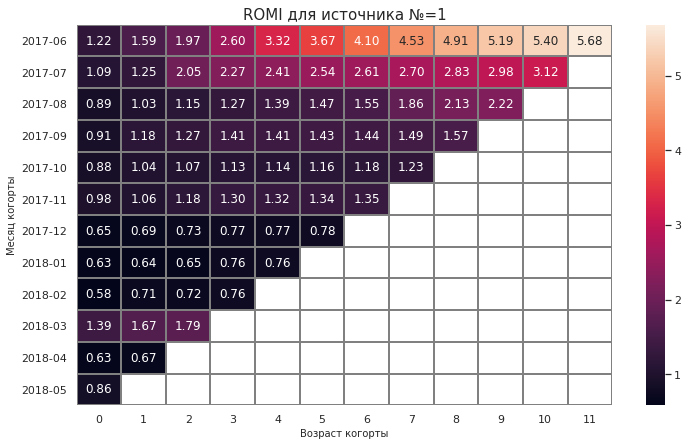

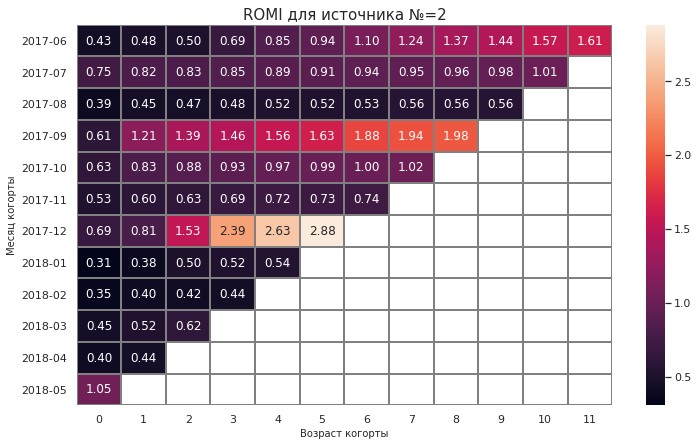

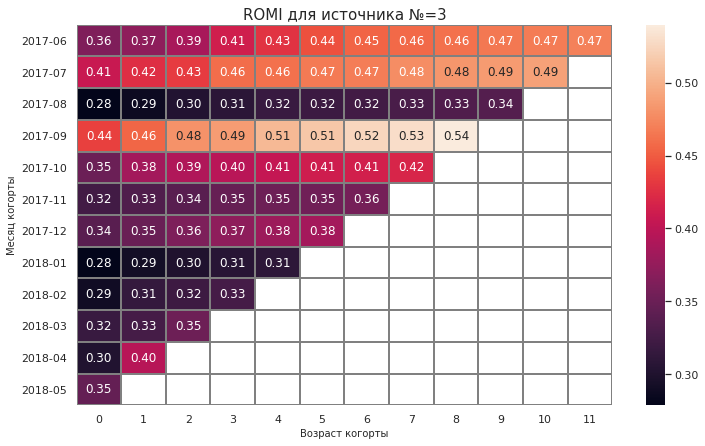

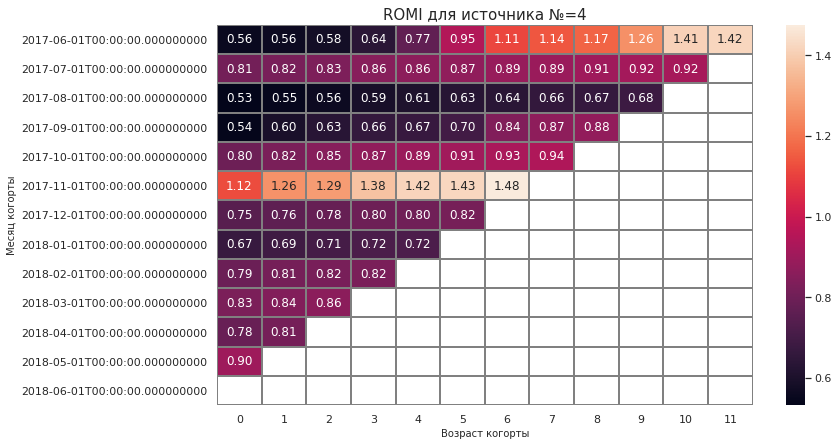

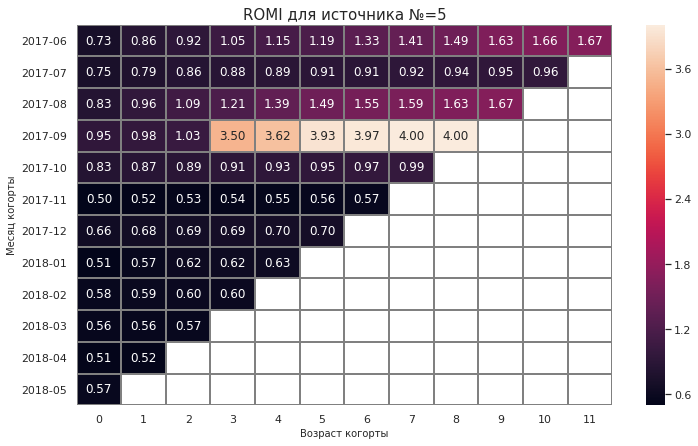

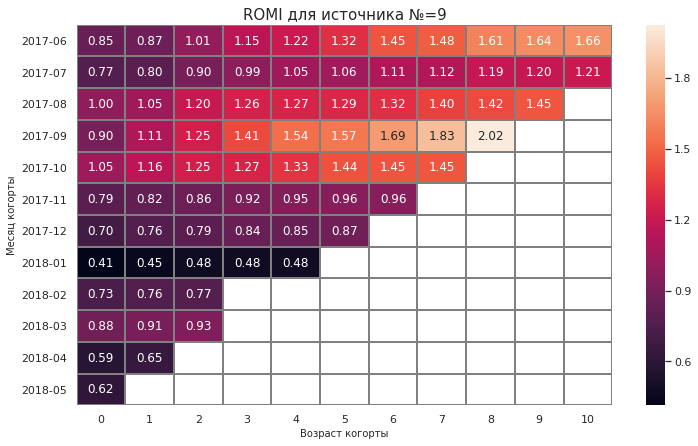

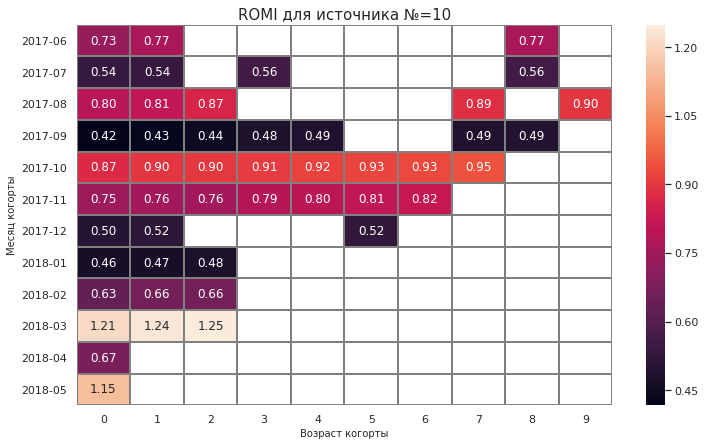

In [140]:
# создаём цикл для подсчёта romi по каждому источнику трафика
sources = [1,2,3,4,5,9,10]
for source in sources :
    source_orders = orders_newest.query('source_id == @source')
    cohort_sizes = (source_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    
    cohorts_for_ltv = (source_orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index())
    cohorts_for_ltv['first_order_month'] = cohorts_for_ltv['first_order_month'].astype('datetime64[ns]')
    cohorts_for_ltv['order_month'] = cohorts_for_ltv['order_month'].astype('datetime64[ns]')
    report_for_ltv = pd.merge(cohort_sizes, cohorts_for_ltv, on='first_order_month')
    
    
    margin_rate = 1
    report_for_ltv['gp'] = report_for_ltv['revenue'] * margin_rate
    report_for_ltv['age'] = (report_for_ltv['order_month'] - report_for_ltv['first_order_month']) / np.timedelta64(1, 'M')
    report_for_ltv['age'] = report_for_ltv['age'].round().astype('int')
    report_for_ltv['ltv'] = report_for_ltv['gp'] / report_for_ltv['n_buyers']
    report_for_ltv['first_order_month'] = report_for_ltv['first_order_month'].dt.strftime('%Y-%m')
    output2 = report_for_ltv.pivot_table(index='first_order_month', columns='age', 
                                         values='ltv',aggfunc='mean').cumsum(axis=1)#.fillna(0)
    #print('LTV по источникy трафика:', source)
    #display(output2)
    
    source_costs = costs.query('source_id == @source')
    source_costs['month'] = source_costs['date'].astype('datetime64[M]')
    source_costs = source_costs.groupby('month').agg({'costs':'sum'})
    source_costs = source_costs.join(cohort_sizes.set_index('first_order_month'))
    source_costs['cac'] = source_costs['costs'] / source_costs['n_buyers']
       
    out_romi = output2.div(source_costs['cac'], axis=0)
    
    sns.set(style = 'white')
    plt.figure(figsize = (12, 7))
    sns.heatmap(data = out_romi, annot = True, fmt = '.2f', linewidths = 1, linecolor='gray')
    plt.ylabel('Месяц когорты', fontsize = 10)
    plt.xlabel('Возраст когорты', fontsize = 10) 
    plt.title('ROMI для источника №={}'.format(source), fontsize = 15)

Высокий показатель ROMI у 1, 2, 4, 5 и 9 источников. Небольшой у 3 и 10.

## Вывод

Мы подготовили данные, изменили тип данных в нужных местах. Приступили к расчету метрик: продуктовых, электронной коммерции, маркетинговых.

Количество уникальных пользователей в день DAU = 907. Каждую неделю происходит взлет посещений и падение. <br>
Количество уникальных пользователей в неделю WAU = 5621. В летнее время количество посещений низкое. Пик на Новый год. <br>
Количество уникальных пользователей в месяц MAU =23228. непрерывный рост с августа по ноябрь. <br>
 <br>
В день один пользователь в среднем проводит 1 сессию. Регулярность высокая. <br>
Одну минуту длится в среднем сессия по моде. Пользователи заходят на сайт, просматривают афишу изакрывают страницу. Около 10,5 минут - по медиане. <br>
<br>
Retention Rate в целом низкий и убывает по когортам с течением времени. Если для когорты пользователей, пришедших в июне 2017 Retention Rate в первую неделю составляет 7,9%, то для пользователей, пришедших в апреле 2018 — уже 4,8%. За 10 мес коэффициент удержания упал на 3,1%. Это говорит, что с каждой новой когортой поведение покупателей меняется.
Коэффициент удержания у первой когорты заметно выше, чем у других; маркетологам нужно внимательно изучить эту когорту и выяснить причины лояльности. Выделяется июльская когорта - в середине лета пользователей меньше.
 

Вычислили моду разницы во времени с момента первого посещения сайта до совершения покупки - 1 минута. Медиана - 16 минут.
Посчитали среднее число покупок для каждой когорты с накоплением. Показатель у всех когорт с каждым месяцем увеличивается.  <br> Первая когорта с высоким Retention снова в лидерах. Она совершают больше покупок в месяц. Среднее количество покупок на одного покупателя за 6 месяцев = 7,8 у.е.  <br>
Средний чек по медиане - 2,5 у.е., по моде - 1,83 у.е.
Максимальный средний чек в июле 2017 и июне 2018. Минимальный в июне 2017, январе и июне 2018. <br>

LTV всех когорт увеличивается со временем. Накопительный LTV намного выше у первых когорт 2017г. Первая когорта почти в каждом месяце она имеет высший LTV среди всех когорт. Ведь именно эта когорта показала лучший показатель Retention. В когорте сентября на третий месяц жизни наблюдаем резкий скачок LTV - необходимо исследовать это подробнее.
Средний LTV за полгода = 40 у.е.

На маркетинг потратили всего денег 329 131 у.е. <br>
Третий источник - безоговорочный лидер по суммарным тратам, более 50% от суммы всех вложений. На 2м месте четвертый источник - но на него потрачено в 2,3 раза меньше. Далее 4, 5, 1. Самый низкий бюджет у 9 и 10.  <br> По месяцам на третий источник тоже тратят самый большой бюджет, затем идут 4 и 5й. Во все источники вкладывают максимум в зимний период с октября по январь, минимум - в августе.


Средний СAC по всем группам 9 у.е. <br>
Усреднили ROMI всех когорт за каждый месяц их жизни. В среднем когорты окупаются после 9 месяца. <br>
Высокий показатель ROMI у 1, 2, 4, 5 и 9 источников. Небольшой у 3 и 10.  <br>


Стоит пересмотреть источник 3 - он имеет самый низкий ROMI и самый большие вложения. 
Также интересен истоничк 9 - бюджет небольшой, но ROMI высокий.

Так как первая когорта по показателям выделяется среди прочих, то можно рекомендовать пристально исследовать данную когорту, другие когорты изучить опросов и интервью и сравнить с первой.  <br> <br>